In [3]:
import pandas as pd
import numpy as np
import os
import pickle

import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.utils import shuffle
from plsr import PLSRComponents
from plsr import validate_plot
from brokenaxes import brokenaxes

from preprocessing.dataset import DatasetSpectra

In [4]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [5]:
file_path = '../data/dataset_681.csv'
domain_path = '../data/domain2.csv'

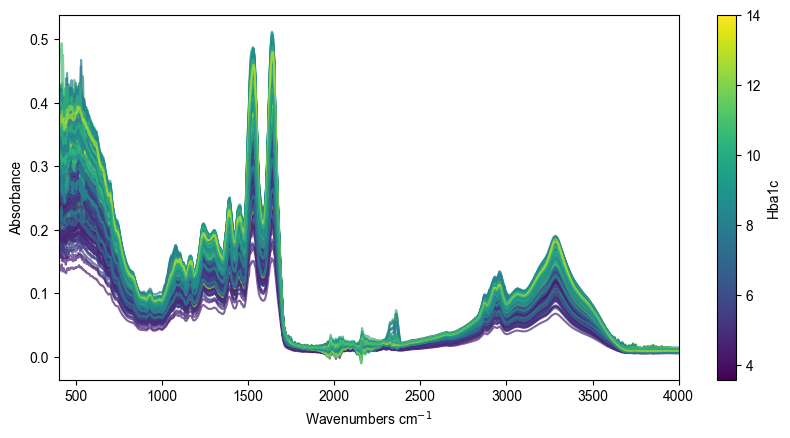

In [6]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.select_max_hba1c(14)
dataset.select_region([400, 4000])
dataset.drop_samples([287, 636])
fig1, ax1 = dataset.plot_spectra()
plt.subplots_adjust(bottom=0.15)
plt.savefig('../figures/spectra_before_preproc.png', dpi=300, transparent=True)
plt.savefig('../figures/spectra_before_preproc.pdf', format='pdf')

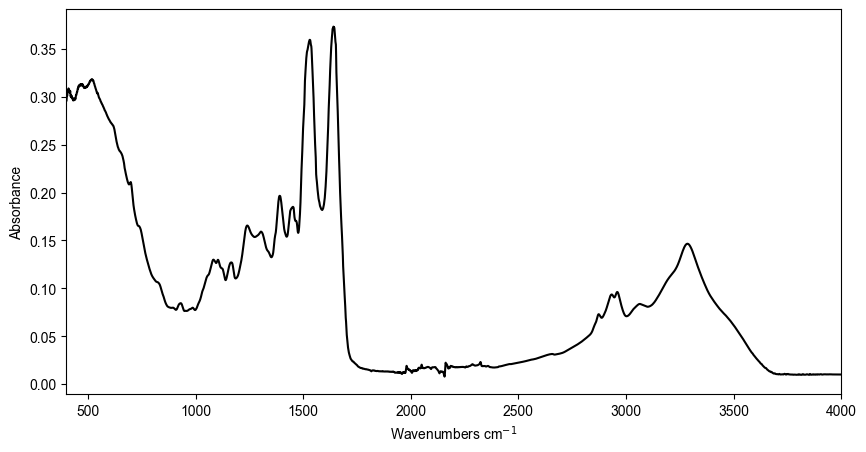

In [7]:
plt.figure(figsize=(10, 5))

spectra = dataset.spectra.mean(axis=0)
wn = dataset.wavenumbers
plt.plot(wn, spectra, color='k')
plt.xlabel("Wavenumbers cm$^{-1}$")
plt.ylabel("Absorbance")
plt.xlim([400, 4000])
plt.savefig('../figures/mean_spectra_before.png', dpi=300, transparent=True)

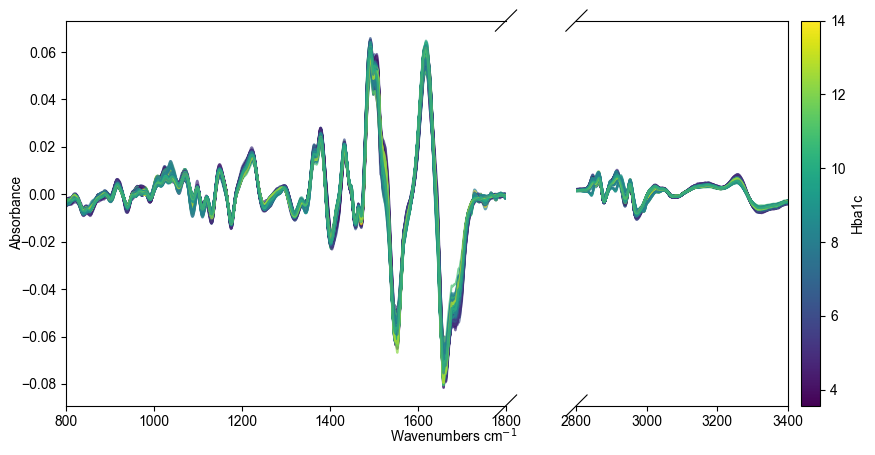

In [8]:
# dataset.baseline_corr()
dataset.savgol_filter(window_length=32, polyorder=2, deriv=1)
dataset.normalization('vector')
dataset.select_region([[800, 1800], [2800, 3400]])
# dataset.select_region([800, 1800])
fig2, ax2 = dataset.plot_spectra()
plt.savefig('../figures/spectra_after_preproc.png', dpi=300, transparent=True)
plt.savefig('../figures/spectra_after_preproc.pdf', format='pdf')

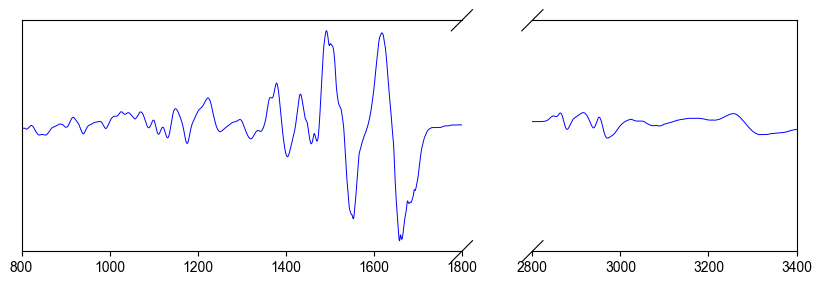

In [9]:
fig = plt.figure(figsize=(10, 3))
bax = brokenaxes(xlims=((800, 1800), (2800, 3400)), hspace=0.1, despine=False)

bax.plot(dataset.wavenumbers, dataset[0][0], linewidth=0.7, color='b')

for ax in bax.axs:
    # ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.savefig('../figures/spectra_after_preproc_single.png', dpi=300, transparent=True)

(<Figure size 1000x500 with 2 Axes>,
 <Axes: xlabel='Wavenumbers cm$^{-1}$', ylabel='Absorbance'>)

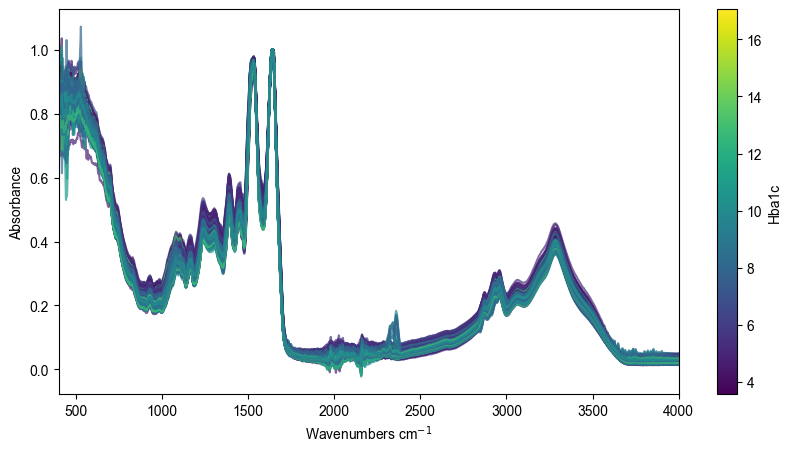

In [10]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.normalization(kind='amide')
dataset.select_region([400, 4000])

spectra = dataset.spectra
wavenumbers = dataset.wavenumbers
hba1c = dataset.hba1c

dataset.plot_spectra()

In [11]:
spectra.shape

(681, 7466)

In [12]:
hba1c.shape

(681,)

In [13]:
df_spectra = pd.DataFrame(spectra)
df_spectra['HbA1c'] = hba1c

In [14]:
q25, q75 = np.percentile(hba1c, [25, 75])

print("Q1:", q25, "Q3:", q75)

hba1c_q25 = hba1c <= q25
hba1c_q75 = hba1c >= q75

Q1: 5.3 Q3: 8.93


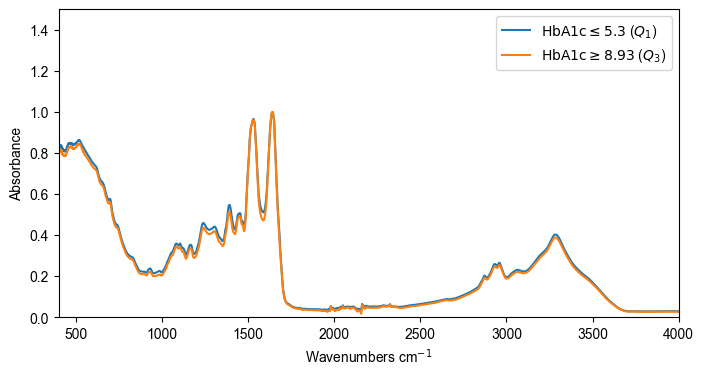

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(wavenumbers, spectra[hba1c_q25].mean(axis=0), label=r'$\text{HbA1c} \leq 5.3$ ($Q_1$)')
plt.plot(wavenumbers, spectra[hba1c_q75].mean(axis=0), label=r'$\text{HbA1c} \geq 8.93$ ($Q_3$)')

plt.xlabel("Wavenumbers cm$^{-1}$")
plt.ylabel("Absorbance")
plt.xlim([400, 4000])
plt.ylim([0.0, 1.5])
plt.legend()

plt.savefig("../figures/mean_spectra_hba1c.png", dpi=300, transparent=True)

In [16]:
df = pd.read_csv(file_path)

In [17]:
(df['HbA1c'] >= 8.93).sum()

np.int64(171)

In [18]:
(df['HbA1c'] <= 5.3).sum()

np.int64(171)

In [19]:
all_varimp = pd.read_csv('../data/curvefit_results/top_varimp_height.csv')
all_varimp

,variable,relative_importance,scaled_importance,percentage,model_id
0,1574,2055.453613,1.000000,0.146074,GBM_grid_1_AutoML_1_20250311_204849_model_8
1,1313,1429.690308,0.695560,0.101603,GBM_grid_1_AutoML_1_20250311_204849_model_8
2,1402,1104.809570,0.537502,0.078515,GBM_grid_1_AutoML_1_20250311_204849_model_8
3,1366,1027.902344,0.500085,0.073050,GBM_grid_1_AutoML_1_20250311_204849_model_8
4,1011,747.595276,0.363713,0.053129,GBM_grid_1_AutoML_1_20250311_204849_model_8
...,...,...,...,...,...
195,1011,730.876648,0.303171,0.058703,GBM_grid_1_AutoML_1_20250311_204849_model_11
196,1502,604.545715,0.250768,0.048556,GBM_grid_1_AutoML_1_20250311_204849_model_11
197,1051,376.945557,0.156359,0.030276,GBM_grid_1_AutoML_1_20250311_204849_model_11
198,1104,317.385376,0.131653,0.025492,GBM_grid_1_AutoML_1_20250311_204849_model_11


In [20]:
all_varimp.columns

Index(['variable', 'relative_importance', 'scaled_importance', 'percentage',
       'model_id'],
      dtype='object')

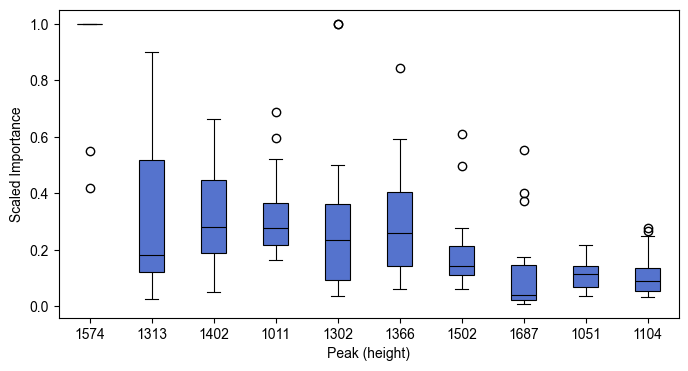

In [21]:
top_features = all_varimp.groupby('variable')['scaled_importance'].mean().nlargest(10).index

top_varimp = all_varimp[all_varimp['variable'].isin(top_features)]

plt.figure(figsize=(8, 4))
sns.boxplot(x='variable', y='scaled_importance', 
            data=top_varimp, color='royalblue', linecolor='k',
            order=top_features, linewidth=0.8, width=0.4)

# plt.title('Top 10 Most Important Features Across Models')
plt.ylabel('Scaled Importance')
plt.xlabel("Peak (height)")
plt.savefig("../figures/top_varimp_height.png", transparent=True, dpi=300)

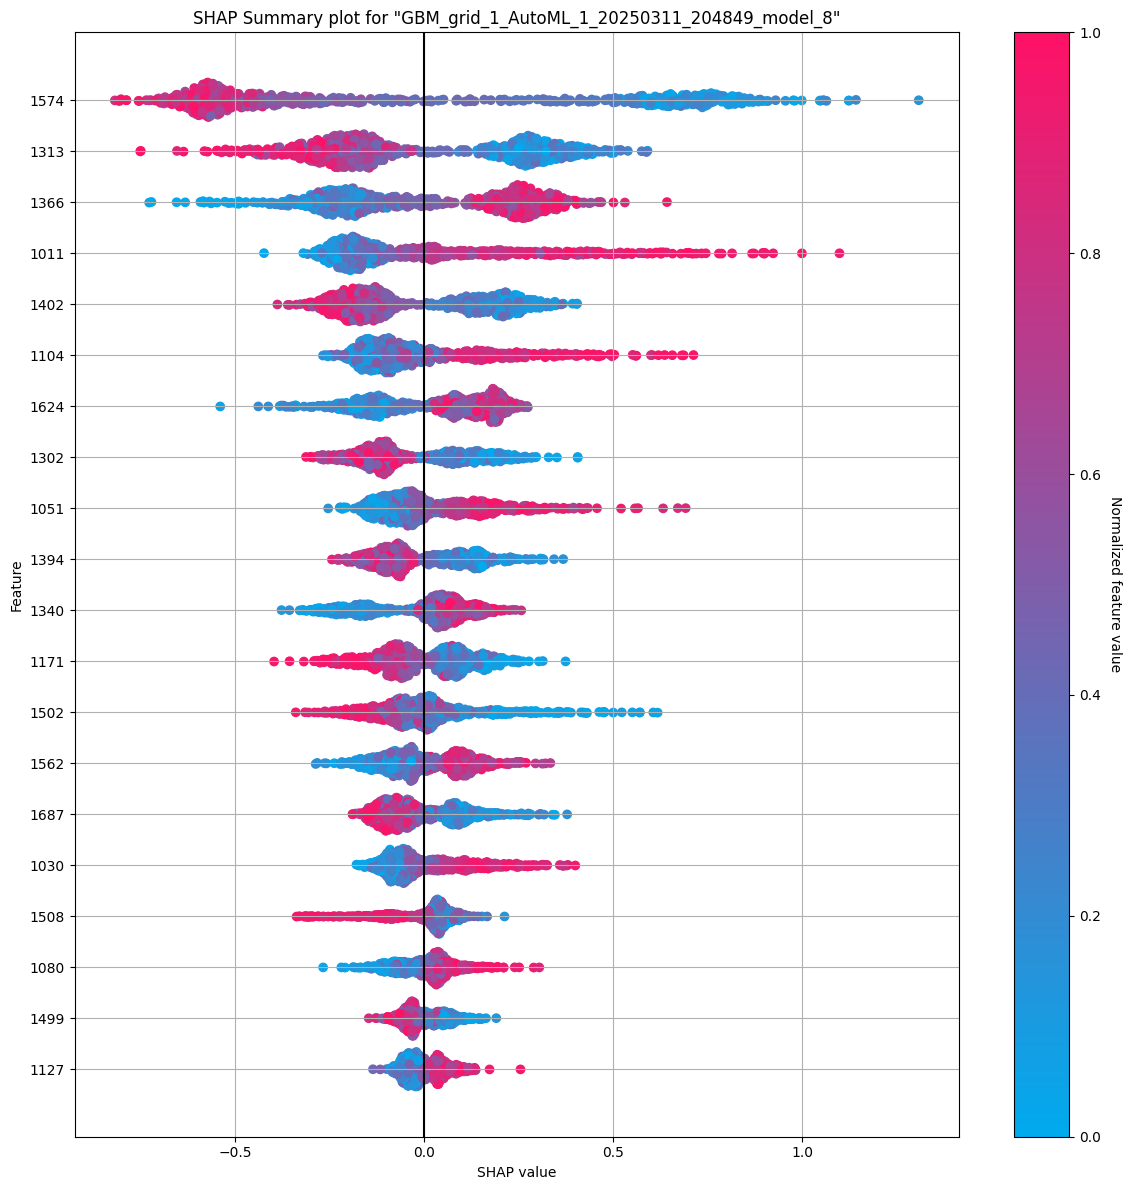

In [22]:
with open("../data/curvefit_results/SHAP_height.pkl", "rb") as f:
    shap_height = pickle.load(f)
plt.savefig('../figures/SHAP_height.png', transparent=True, dpi=300)

In [23]:
with open("../data/curvefit_results/leader_varimp.pkl", "rb") as f:
    varimp = pickle.load(f)

columns = ['variable', 'relative_importance', 'scaled_importance', 'percentage']
varimp_leader = pd.DataFrame(varimp, columns=columns)

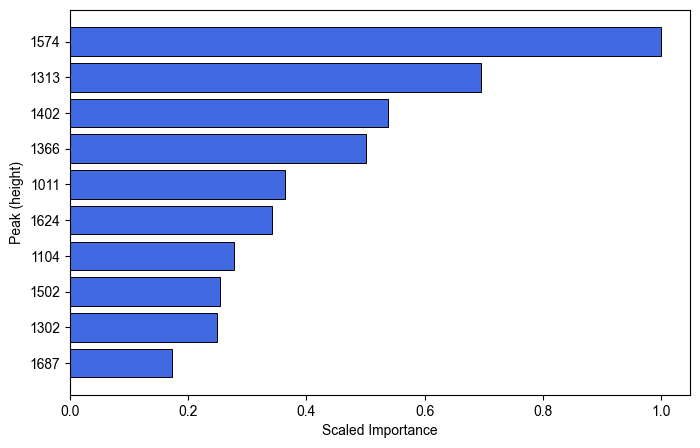

In [24]:
plt.figure(figsize=(8, 5))
plt.barh(varimp_leader["variable"].iloc[:10].astype(str), 
         varimp_leader["scaled_importance"].iloc[:10], color='royalblue',
         edgecolor='k', linewidth=0.7
         )
plt.gca().invert_yaxis()
plt.xlabel("Scaled Importance")
plt.ylabel("Peak (height)")
plt.savefig("../figures/varimp_top_glm_model.png", transparent=True, dpi=300)

In [25]:
res = pd.read_csv('../data/curvefit_results/predict_curvefit_height.csv')
y_true, y_pred_cf = res.T.to_numpy()

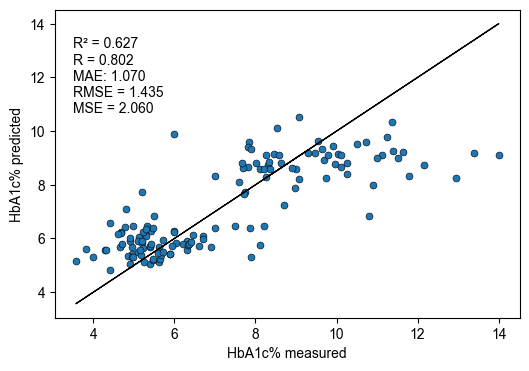

In [26]:
fig, ax = validate_plot(y_true, y_pred_cf, params={"x": 3.5, "y": 13.5})
plt.savefig("../figures/validation_curvefit.png", transparent=True, dpi=300)

In [27]:
data_cnn = np.load('../data/predict_cnn.npy')
y_pred_cnn, y_true_cnn = data_cnn.T

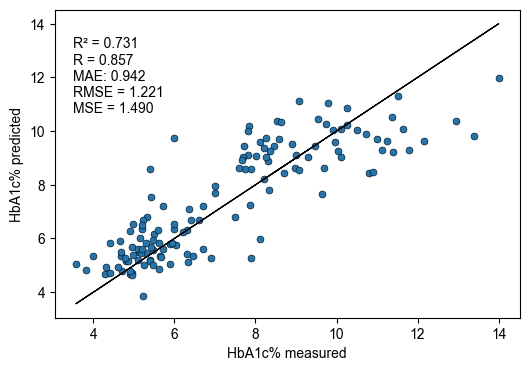

In [28]:
fig, ax = validate_plot(y_true_cnn, y_pred_cnn, params={"x": 3.5, "y": 13.5})
plt.savefig("../figures/validation_cnn.png", transparent=True, dpi=300)

In [48]:
peaks = pd.read_csv('../data/peaks_56.csv')

START = 1000
END = 1720
MAX_HBA1C = 14
NORMALIZATION = 'amide'
START_INDEX = 0
SAVGOL_PARAMS = {
    "window_length": 5,
    "polyorder": 3
}

dataset = DatasetSpectra(file_path, domain_path)
dataset.select_max_hba1c(14)
dataset.drop_samples([287, 636])
dataset.savgol_filter(**SAVGOL_PARAMS)
dataset.baseline_corr()
dataset.normalization(kind=NORMALIZATION)
dataset.select_region([START, END])

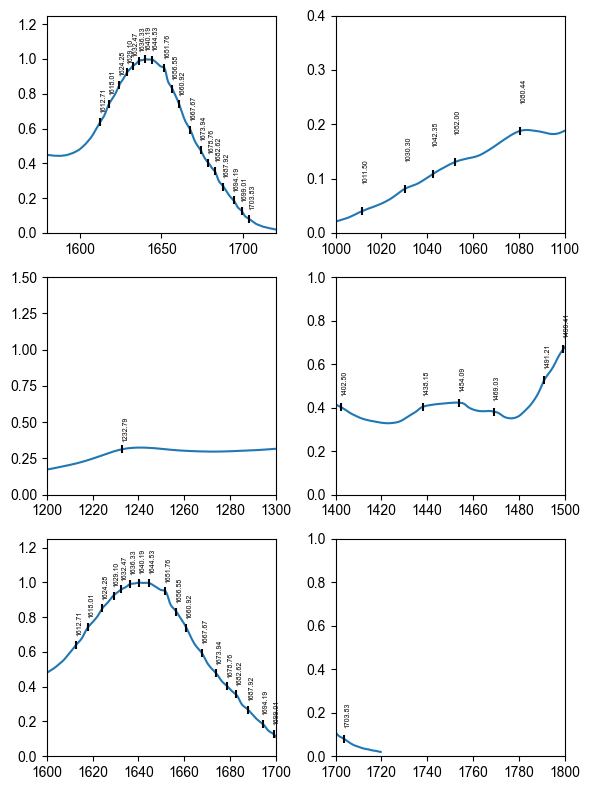

In [81]:
fig, axs = plt.subplots(3, 2, figsize=(6, 8))

indices = np.where(np.isin(wavenumbers, peaks.values.reshape(-1)))[0]

spectra = dataset.spectra.mean(axis=0)
wavenumbers = dataset.wavenumbers

# Define the limits for each subplot
limits = [
    (1580, 1720, 0, 1.25),
    (1000, 1100, 0, 0.4),
    (1200, 1300, 0, 1.5),
    (1400, 1500, 0, 1.0),
    (1600, 1700, 0, 1.25),
    (1700, 1800, 0, 1.0)
]

for ax, (xmin, xmax, ymin, ymax) in zip(axs.flatten(), limits):
    ax.plot(wavenumbers, spectra)
    ax.scatter(wavenumbers[indices], spectra[indices], marker='|', s=40, c='k', zorder=5)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    for i in indices:
        position = wavenumbers[i]
        if xmin <= position <= xmax:
            ax.text(wavenumbers[i], spectra[i] + 0.05, f'{wavenumbers[i]:.2f}', 
                    rotation=90, verticalalignment='bottom', fontsize=5)

plt.tight_layout()
plt.show()

In [ ]:
indices = np.where(np.isin(wavenumbers, peaks.values.reshape(-1)))[0]

[  23   62   87  107  166  216  263  329  355  482  627  649  705  760
  801  818  834  908  941  972 1018 1035 1042 1053 1064 1073 1083 1096
 1104 1116 1127 1136 1146 1156 1166 1177 1191 1270 1281 1294 1304 1311
 1319 1327 1336 1351 1361 1370 1384 1397 1407 1415 1426 1439 1449 1459]
